# Generating dataset, splitting into train-test data and preprocessing

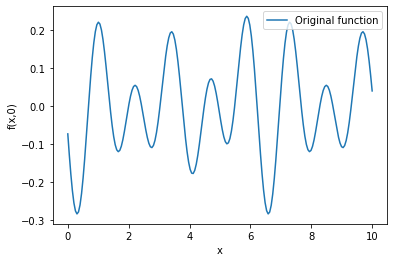

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time
import numpy.random as npr

torch.set_default_tensor_type(torch.DoubleTensor)

t = 0
N = 20
L = 2*math.pi
x = torch.linspace(0,10,200)
f = torch.tensor(0.0)
del_x = x[4]-x[3]

np.random.seed(0)
for i in range(1,N+1):
    A = np.random.uniform(low = -0.1, high = 0.1)
    w = np.random.uniform(low = -0.4, high = 0.4)
    phi = np.random.uniform(low = 0.0, high = 2*math.pi)
    l = np.random.choice([2,3,4,5])
    f = f + A*torch.sin(w*t + (2*math.pi*l*x)/L +phi)


plt.plot(x,f,label = 'Original function')
plt.xlabel('x')
plt.ylabel('f(x,0)')
plt.legend()

N = f.size(0)
testPct = 0.5     #train-test split
nTrain = int(N*(1.-testPct))

train_data = f[:nTrain].to("cuda")
test_data = f[nTrain:].to("cuda")

def make_patches(data):
    inputs = torch.DoubleTensor(data.size(0)-2,2)
    outputs = torch.DoubleTensor(data.size(0)-2,1)
    inputs = inputs.cuda()
    outputs = outputs.cuda()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    outputs = torch.autograd.Variable(outputs, requires_grad=True)
    for i in range(0, data.size(0)-2):
        inputs.data[i] = torch.DoubleTensor([data[i],data[i+2]])
        outputs.data[i] = data[i+1]
        
    return inputs,outputs

# Model Building and Training

In [2]:
class Reconstruct(torch.nn.Module):
    def __init__(self,seed = 0):
        super().__init__()
        torch.manual_seed(seed)                              
        self.fc1 = torch.nn.Linear(2,16)
        self.fc2 = torch.nn.Linear(16,2)
        
    def forward(self,x):
        x = self.make_inputs(x)
        x = self.fc1(x)
        x = torch.nn.functional.elu(self.fc2(x))
        return x
    
    def make_inputs(self,x):
        inputs = torch.DoubleTensor(x.size(0)-2,2)
        inputs = inputs.cuda()
        inputs = torch.autograd.Variable(inputs, requires_grad=True)
        for i in range(0, x.size(0)-2):
            inputs.data[i] = torch.DoubleTensor([x[i],x[i+2]])
        return inputs
    
def train(epoch,model,optimizer,train_data,train_inputs,train_outputs):
        
    optimizer.zero_grad()
    pred = model(train_data)
    loss = torch.nn.MSELoss()((pred*train_inputs).sum(1), train_outputs.flatten())
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tLoss: {:.4f}'.format(epoch, loss))
    
    return loss.item()
    
def test(epoch,model,optimizer,test_data,test_inputs,test_outputs):
     
    pred = model(test_data) 
    loss = torch.nn.MSELoss()((pred*test_inputs).sum(1), test_outputs.flatten())
    
    print('TEST SET RESULTS')
    print('Average loss: {:.4f}'.format(loss))
    
    return loss.item()

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = Reconstruct(seed = seed)
if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_inputs, train_outputs = make_patches(train_data)
test_inputs, test_outputs = make_patches(test_data)
test_loss = []
train_loss = []
epochs = 100
start = time.time()
for epoch in tqdm(range(epochs)):
    trainloss = train(epoch,model,optimizer,train_data,train_inputs,train_outputs)
    testloss = test(epoch,model,optimizer,test_data,test_inputs,test_outputs)
    test_loss.append(testloss)
    train_loss.append(trainloss)
    #if testloss <= 1e-2:
     #   break

print ("Training time : ",time.time()-start)
print("Test loss after 100 epochs:",test_loss[-1])
print("Training loss after 100 epochs:",train_loss[-1])

  3%|██▍                                                                               | 3/100 [00:01<00:29,  3.32it/s]

Epoch: 0 	Loss: 0.0331
TEST SET RESULTS
Average loss: 0.0361
Epoch: 1 	Loss: 0.0326
TEST SET RESULTS
Average loss: 0.0355
Epoch: 2 	Loss: 0.0321
TEST SET RESULTS
Average loss: 0.0349
Epoch: 3 	Loss: 0.0316
TEST SET RESULTS
Average loss: 0.0344


  7%|█████▋                                                                            | 7/100 [00:01<00:11,  8.21it/s]

Epoch: 4 	Loss: 0.0311
TEST SET RESULTS
Average loss: 0.0338
Epoch: 5 	Loss: 0.0305
TEST SET RESULTS
Average loss: 0.0333
Epoch: 6 	Loss: 0.0300
TEST SET RESULTS
Average loss: 0.0327
Epoch: 7 	Loss: 0.0295
TEST SET RESULTS


  9%|███████▍                                                                          | 9/100 [00:01<00:08, 10.45it/s]

Average loss: 0.0322
Epoch: 8 	Loss: 0.0290
TEST SET RESULTS
Average loss: 0.0316
Epoch: 9 	Loss: 0.0285
TEST SET RESULTS
Average loss: 0.0311
Epoch: 10 	Loss: 0.0280
TEST SET RESULTS
Average loss: 0.0305
Epoch: 11 	Loss: 0.0275


 15%|████████████▏                                                                    | 15/100 [00:01<00:05, 15.00it/s]

TEST SET RESULTS
Average loss: 0.0300
Epoch: 12 	Loss: 0.0270
TEST SET RESULTS
Average loss: 0.0295
Epoch: 13 	Loss: 0.0265
TEST SET RESULTS
Average loss: 0.0289
Epoch: 14 	Loss: 0.0260
TEST SET RESULTS
Average loss: 0.0284
Epoch: 15 	Loss: 0.0255


 17%|█████████████▊                                                                   | 17/100 [00:01<00:05, 15.95it/s]

TEST SET RESULTS
Average loss: 0.0279
Epoch: 16 	Loss: 0.0251
TEST SET RESULTS
Average loss: 0.0274
Epoch: 17 	Loss: 0.0246
TEST SET RESULTS
Average loss: 0.0269
Epoch: 18 	Loss: 0.0241
TEST SET RESULTS
Average loss: 0.0263
Epoch: 19 	Loss: 0.0236


 23%|██████████████████▋                                                              | 23/100 [00:02<00:04, 18.10it/s]

TEST SET RESULTS
Average loss: 0.0258
Epoch: 20 	Loss: 0.0232
TEST SET RESULTS
Average loss: 0.0253
Epoch: 21 	Loss: 0.0227
TEST SET RESULTS
Average loss: 0.0248
Epoch: 22 	Loss: 0.0223
TEST SET RESULTS
Average loss: 0.0244
Epoch: 23 	Loss: 0.0218


 26%|█████████████████████                                                            | 26/100 [00:02<00:03, 18.70it/s]

TEST SET RESULTS
Average loss: 0.0239
Epoch: 24 	Loss: 0.0213
TEST SET RESULTS
Average loss: 0.0234
Epoch: 25 	Loss: 0.0209
TEST SET RESULTS
Average loss: 0.0229
Epoch: 26 	Loss: 0.0205
TEST SET RESULTS
Average loss: 0.0224
Epoch: 27 	Loss: 0.0200


 30%|████████████████████████▎                                                        | 30/100 [00:02<00:03, 18.55it/s]

TEST SET RESULTS
Average loss: 0.0219
Epoch: 28 	Loss: 0.0196
TEST SET RESULTS
Average loss: 0.0215
Epoch: 29 	Loss: 0.0191
TEST SET RESULTS
Average loss: 0.0210
Epoch: 30 	Loss: 0.0187
TEST SET RESULTS
Average loss: 0.0205
Epoch: 31 	Loss: 0.0183


 35%|████████████████████████████▎                                                    | 35/100 [00:02<00:03, 19.18it/s]

TEST SET RESULTS
Average loss: 0.0201
Epoch: 32 	Loss: 0.0179
TEST SET RESULTS
Average loss: 0.0196
Epoch: 33 	Loss: 0.0175
TEST SET RESULTS
Average loss: 0.0192
Epoch: 34 	Loss: 0.0170
TEST SET RESULTS
Average loss: 0.0187
Epoch: 35 	Loss: 0.0166
TEST SET RESULTS


 39%|███████████████████████████████▌                                                 | 39/100 [00:02<00:03, 19.19it/s]

Average loss: 0.0183
Epoch: 36 	Loss: 0.0162
TEST SET RESULTS
Average loss: 0.0179
Epoch: 37 	Loss: 0.0158
TEST SET RESULTS
Average loss: 0.0174
Epoch: 38 	Loss: 0.0154
TEST SET RESULTS
Average loss: 0.0170
Epoch: 39 	Loss: 0.0150
TEST SET RESULTS


 43%|██████████████████████████████████▊                                              | 43/100 [00:03<00:03, 18.49it/s]

Average loss: 0.0166
Epoch: 40 	Loss: 0.0146
TEST SET RESULTS
Average loss: 0.0162
Epoch: 41 	Loss: 0.0143
TEST SET RESULTS
Average loss: 0.0158
Epoch: 42 	Loss: 0.0139
TEST SET RESULTS
Average loss: 0.0154
Epoch: 43 	Loss: 0.0135


 47%|██████████████████████████████████████                                           | 47/100 [00:03<00:02, 18.33it/s]

TEST SET RESULTS
Average loss: 0.0150
Epoch: 44 	Loss: 0.0131
TEST SET RESULTS
Average loss: 0.0146
Epoch: 45 	Loss: 0.0128
TEST SET RESULTS
Average loss: 0.0142
Epoch: 46 	Loss: 0.0124
TEST SET RESULTS
Average loss: 0.0138


 49%|███████████████████████████████████████▋                                         | 49/100 [00:03<00:02, 18.28it/s]

Epoch: 47 	Loss: 0.0120
TEST SET RESULTS
Average loss: 0.0134
Epoch: 48 	Loss: 0.0117
TEST SET RESULTS
Average loss: 0.0130
Epoch: 49 	Loss: 0.0113
TEST SET RESULTS
Average loss: 0.0126
Epoch: 50 	Loss: 0.0110
TEST SET RESULTS


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:03<00:02, 18.72it/s]

Average loss: 0.0123
Epoch: 51 	Loss: 0.0107
TEST SET RESULTS
Average loss: 0.0119
Epoch: 52 	Loss: 0.0103
TEST SET RESULTS
Average loss: 0.0115
Epoch: 53 	Loss: 0.0100
TEST SET RESULTS
Average loss: 0.0112
Epoch: 54 	Loss: 0.0097


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:03<00:02, 18.85it/s]

TEST SET RESULTS
Average loss: 0.0108
Epoch: 55 	Loss: 0.0093
TEST SET RESULTS
Average loss: 0.0105
Epoch: 56 	Loss: 0.0090
TEST SET RESULTS
Average loss: 0.0102
Epoch: 57 	Loss: 0.0087
TEST SET RESULTS
Average loss: 0.0098
Epoch: 58 	Loss: 0.0084


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:04<00:02, 18.55it/s]

TEST SET RESULTS
Average loss: 0.0095
Epoch: 59 	Loss: 0.0081
TEST SET RESULTS
Average loss: 0.0092
Epoch: 60 	Loss: 0.0078
TEST SET RESULTS
Average loss: 0.0089
Epoch: 61 	Loss: 0.0075
TEST SET RESULTS
Average loss: 0.0085
Epoch: 62 	Loss: 0.0073


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:01, 19.10it/s]

TEST SET RESULTS
Average loss: 0.0082
Epoch: 63 	Loss: 0.0070
TEST SET RESULTS
Average loss: 0.0079
Epoch: 64 	Loss: 0.0067
TEST SET RESULTS
Average loss: 0.0076
Epoch: 65 	Loss: 0.0064
TEST SET RESULTS
Average loss: 0.0074
Epoch: 66 	Loss: 0.0062
TEST SET RESULTS


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:04<00:01, 18.79it/s]

Average loss: 0.0071
Epoch: 67 	Loss: 0.0059
TEST SET RESULTS
Average loss: 0.0068
Epoch: 68 	Loss: 0.0057
TEST SET RESULTS
Average loss: 0.0065
Epoch: 69 	Loss: 0.0054
TEST SET RESULTS
Average loss: 0.0063
Epoch: 70 	Loss: 0.0052


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:04<00:01, 18.81it/s]

TEST SET RESULTS
Average loss: 0.0060
Epoch: 71 	Loss: 0.0050
TEST SET RESULTS
Average loss: 0.0058
Epoch: 72 	Loss: 0.0048
TEST SET RESULTS
Average loss: 0.0056
Epoch: 73 	Loss: 0.0046
TEST SET RESULTS
Average loss: 0.0053
Epoch: 74 	Loss: 0.0044


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:05<00:01, 18.72it/s]

TEST SET RESULTS
Average loss: 0.0051
Epoch: 75 	Loss: 0.0042
TEST SET RESULTS
Average loss: 0.0049
Epoch: 76 	Loss: 0.0040
TEST SET RESULTS
Average loss: 0.0047
Epoch: 77 	Loss: 0.0038
TEST SET RESULTS
Average loss: 0.0045
Epoch: 78 	Loss: 0.0036
TEST SET RESULTS


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:05<00:01, 19.18it/s]

Average loss: 0.0043
Epoch: 79 	Loss: 0.0034
TEST SET RESULTS
Average loss: 0.0041
Epoch: 80 	Loss: 0.0033
TEST SET RESULTS
Average loss: 0.0039
Epoch: 81 	Loss: 0.0031
TEST SET RESULTS
Average loss: 0.0037
Epoch: 82 	Loss: 0.0030


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:05<00:00, 19.21it/s]

TEST SET RESULTS
Average loss: 0.0036
Epoch: 83 	Loss: 0.0028
TEST SET RESULTS
Average loss: 0.0034
Epoch: 84 	Loss: 0.0027
TEST SET RESULTS
Average loss: 0.0033
Epoch: 85 	Loss: 0.0025
TEST SET RESULTS
Average loss: 0.0031
Epoch: 86 	Loss: 0.0024


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:05<00:00, 18.62it/s]

TEST SET RESULTS
Average loss: 0.0030
Epoch: 87 	Loss: 0.0023
TEST SET RESULTS
Average loss: 0.0028
Epoch: 88 	Loss: 0.0022
TEST SET RESULTS
Average loss: 0.0027
Epoch: 89 	Loss: 0.0021
TEST SET RESULTS
Average loss: 0.0026
Epoch: 90 	Loss: 0.0019


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:05<00:00, 18.36it/s]

TEST SET RESULTS
Average loss: 0.0024
Epoch: 91 	Loss: 0.0018
TEST SET RESULTS
Average loss: 0.0023
Epoch: 92 	Loss: 0.0017
TEST SET RESULTS
Average loss: 0.0022
Epoch: 93 	Loss: 0.0017
TEST SET RESULTS
Average loss: 0.0021
Epoch: 94 	Loss: 0.0016


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:06<00:00, 17.13it/s]

TEST SET RESULTS
Average loss: 0.0020
Epoch: 95 	Loss: 0.0015
TEST SET RESULTS
Average loss: 0.0019
Epoch: 96 	Loss: 0.0014
TEST SET RESULTS
Average loss: 0.0018
Epoch: 97 	Loss: 0.0013
TEST SET RESULTS


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.96it/s]

Average loss: 0.0017
Epoch: 98 	Loss: 0.0013
TEST SET RESULTS
Average loss: 0.0017
Epoch: 99 	Loss: 0.0012
TEST SET RESULTS
Average loss: 0.0016
Training time :  6.269395351409912
Test loss after 100 epochs: 0.0015767757617890655
Training loss after 100 epochs: 0.0011913647937985695


# Plotting outputs

Text(0.5, 1.0, 'Sum of 1st order moments for 2 FC layers without moment constraints')

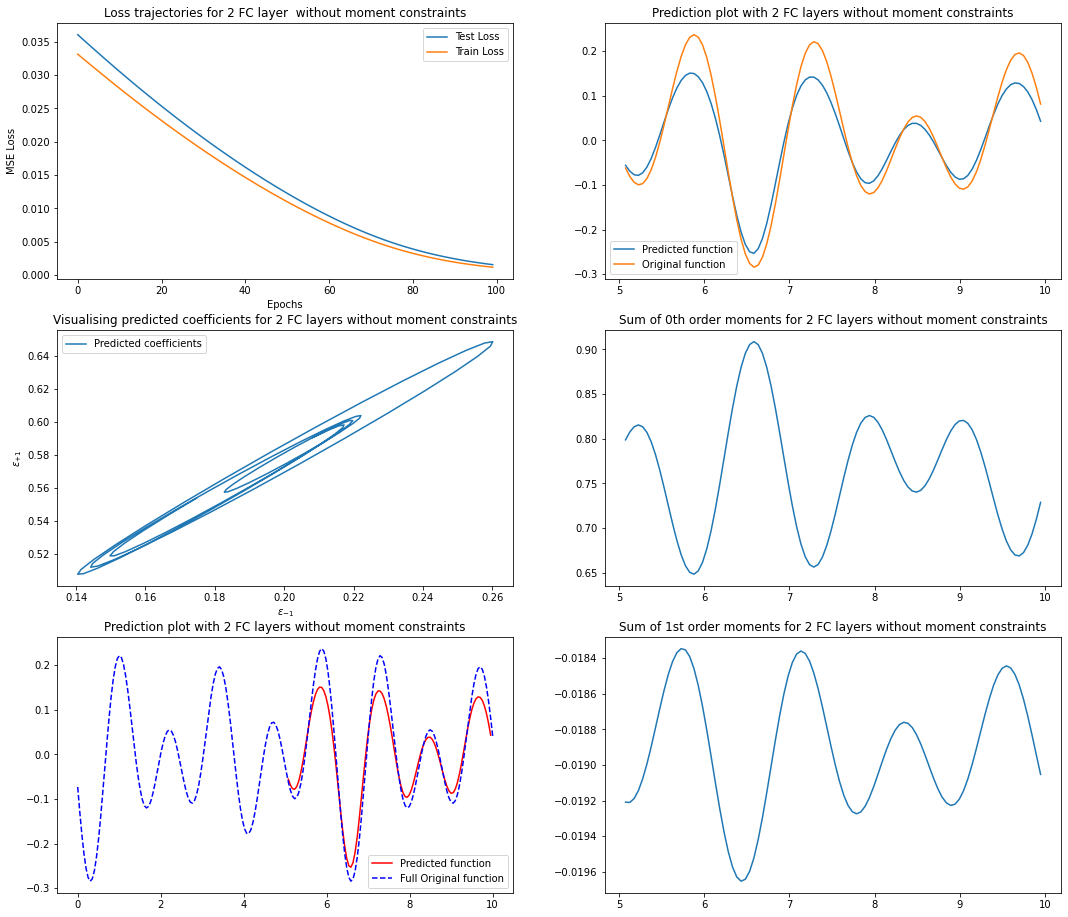

In [3]:
fig, ax = plt.subplots(3, 2)
fig.set_figwidth(18)
fig.set_figheight(16)

ax[0,0].plot(test_loss,label = "Test Loss")
ax[0,0].plot(train_loss,label = "Train Loss")
ax[0,0].legend(loc = "upper right")
#ax[0,0].set_yscale("log")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("MSE Loss")
ax[0,0].set_title("Loss trajectories for 2 FC layer  without moment constraints")

pred = model(test_data)
pred = pred.cpu().detach().numpy()
test_inputs = test_inputs.to('cpu').detach().numpy()
test_outputs = test_outputs.to('cpu').detach().numpy()
ax[0,1].plot(x[-99:-1],(pred*test_inputs).sum(1),label = 'Predicted function')
ax[0,1].plot(x[-99:-1],test_outputs.flatten(),label = 'Original function')
ax[0,1].legend()
ax[0,1].set_title("Prediction plot with 2 FC layers without moment constraints")

ax[1,0].plot(pred[:,0],pred[:,1],label = 'Predicted coefficients')
ax[1,0].legend()
ax[1,0].set_xlabel('$\epsilon_{-1}$')
ax[1,0].set_ylabel('$\epsilon_{+1}$')
ax[1,0].set_title("Visualising predicted coefficients for 2 FC layers without moment constraints")

ax[1,1].plot(x[-99:-1],pred[:,0]+pred[:,1])
ax[1,1].set_title("Sum of 0th order moments for 2 FC layers without moment constraints")

ax[2,0].plot(x[-99:-1],(pred*test_inputs).sum(1),label = 'Predicted function',color = 'red')
ax[2,0].plot(x,f,label = 'Full Original function',color = 'blue',linestyle = 'dashed')
ax[2,0].legend()
ax[2,0].set_title("Prediction plot with 2 FC layers without moment constraints")

ax[2,1].plot(x[-99:-1],(del_x)*pred[:,0]+(-del_x)*pred[:,1])
ax[2,1].set_title("Sum of 1st order moments for 2 FC layers without moment constraints")

# Storing predicted coefficients in text file

In [5]:
f = open("Predicted_coefficients_test_set_without_Cvxpy.txt",'w')
for i in pred:
    f.write(str(i) + "\n")
f.close()